# Create plots for Figure 9

In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.usetex'] = False

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import HeatEqn_FT

In [2]:
# User inputs
data_name = 'Heat_Eqn_exp29'  # Prefix of data files
folder_name = 'Heat_exp29c/'  # Folder to be created for saved output

In [3]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Heat_exp29c/Heat_Eqn_exp29_2019_08_04_05_22_13_599012_model.pkl
0.0710781492292881
0.06387144327163696


In [4]:
# Get all the needed things from the network

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    FT = sess.run(tf.get_default_graph().get_tensor_by_name("encoder/FT:0"))
    IFT = sess.run(tf.get_default_graph().get_tensor_by_name("decoder_inner/IFT:0"))

INFO:tensorflow:Restoring parameters from ./Heat_exp29c/Heat_Eqn_exp29_2019_08_04_05_22_13_599012_model.ckpt


In [5]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            #lc = LineCollection(segments, cmap='spring', norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
            cmap = matplotlib.colors.ListedColormap(['red'])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

PDEsolvers.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  U[ti,:] = np.fft.ifft(np.exp(-D*k**2*t[ti])*u_0t)


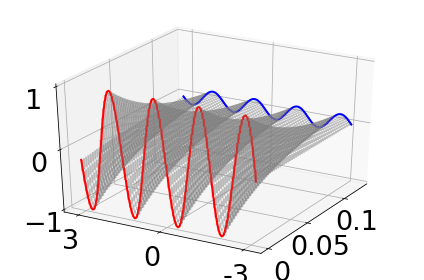

In [6]:
# Plot prediction for sine wave - if 3 side-by-side

# "Exact" solution
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
u_0 = np.sin(4*x_pts)
exact = HeatEqn_FT(D=1,L=2*np.pi,x=x_pts,t=t_pts,u_0=u_0)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=27)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=27)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=27)
plt.tight_layout()
plt.show()

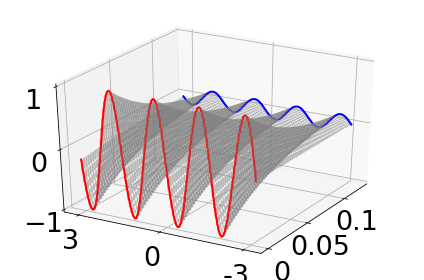

In [7]:
# Linear Network
time_steps = 50
current_encoded = np.matmul(u_0,FT)

linear_network = np.zeros((t_pts.size,x_pts.size))

for n_step in xrange(time_steps):
    linear_network[n_step,:] = np.matmul(current_encoded,IFT)
    current_encoded = np.matmul(current_encoded,L_mat)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(linear_network),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], linear_network[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], linear_network[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=27)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=27)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=27)
plt.tight_layout()
plt.show()

In [8]:
# Nonlinear Network
folder_name = 'Heat_exp29m/'

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Heat_exp29m/Heat_Eqn_exp29_2019_10_28_10_57_58_868266_model.pkl
0.0448733676224947
0.040677424520254135


In [9]:
# Get all the needed things from the network

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    FT = sess.run(tf.get_default_graph().get_tensor_by_name("encoder/FT:0"))
    IFT = sess.run(tf.get_default_graph().get_tensor_by_name("decoder_inner/IFT:0"))

INFO:tensorflow:Restoring parameters from ./Heat_exp29m/Heat_Eqn_exp29_2019_10_28_10_57_58_868266_model.ckpt


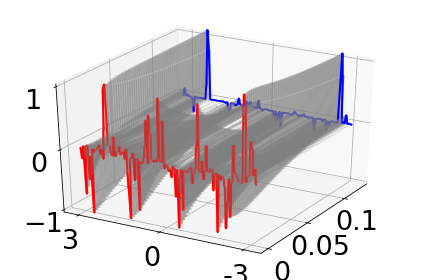

In [10]:
# Nonlinear Network

time_steps = 50
current_encoded = np.matmul(u_0,FT)

nonlinear_network = np.zeros((t_pts.size,x_pts.size))

for n_step in xrange(time_steps):
    nonlinear_network[n_step,:] = np.matmul(current_encoded,IFT)
    current_encoded = np.matmul(current_encoded,L_mat)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(nonlinear_network),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], nonlinear_network[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], nonlinear_network[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=27)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=27)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=27)
plt.tight_layout()
plt.show()